## Радослав, добрый день!

Выполнение этого задания было осложнено объемом данных для работы, поэтому оно выполнено не совсем так, как предполагалось.

На задание по CV нам по запросу выделяли кластеры AWS с лимитом работы на 40 часов, у меня оставалось время, и мне разрешили использовать остатки для этого задания (работать локально или на колабе не выходило — смог сделать только первые 2 basic ноутбука). Но идеально все равно не вышло. Из train датасета надо было приготовить numpy массив с признаками картинок размера 2048х8х8, но не хватало оперативной памяти и пространства хранилища, поэтому я сделал 16 numpy массивов с признаками ( если бы места хватило, то их было бо 20), но нужного размера 2048х8х8. В этом файле https://github.com/andrecpc/made_nlp_wh_4/blob/master/prep.py предобработка данных.

Тренировал модель тоже на AWS, для этого тренировался по очереди на каждой из 16 пар numpy массивов и токенизированных описаний. На каждую пару было 50 эпох, заняло около полутора часов. Loss train был около 2.2, loss val был около 2.8.

После обучения сохранял список токенов "vocab", словарь с индексами и токенами "word_to_index" и веса модели из класса "CaptionNet". Файл обучения тут https://github.com/andrecpc/made_nlp_wh_4/blob/master/train.py.

Полученные файлы загрузил на гугл диск и уже использую в этом ноутбуке, поэтому кода тут не так много. Ну и из-за ограничений по ресурсам я не стал распыляться, проверяя разные архитектуры модели и т.п., а сразу постарался сделать что-то более-менее работающее. К тому же в субботу (27.06.20) обещали отключить AWS со всеми лежащими там файлами, а только вчера (25.06.20) сказали, что облако можно исплльзовать для ДЗ по NLP. (ну тут и я поздно спросил, стараясь что-то сделать локально или в колабе)

---------------------------------
Оба задания из части basic_part тоже выполнили и прикрепил к форме, там немного комментов, потому что просто восстанавливал код по ходу ноутбука.


### Advanced task: image captioning with visual attention

![img](https://i.imgur.com/r3r0fS4.jpg)

__This task__ walks you through all steps required to build an attentive image-to-captioning system. Except this time, there's no `<YOUR CODE HERE>`'s. You write all the code.

You are free to approach this task in any way you want. Follow our step-by-step guide or abandon it altogether. Use the notebook or add extra .py files (remember to add them to your anytask submission). The only limitation is that your code should be readable and runnable top-to-bottom.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using device: cuda



In [3]:
# Загружаем модель из ноутбуков задания, она готовит признаки картинок,
# на этих признаках училась и моя модель

from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """

    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

from torch.utils.model_zoo import load_url

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [4]:
import json
import pickle

# Загружаем словарь с id токенов
word_to_index = json.load(open("/content/gdrive/My Drive/word_to_index.json"))

# Загружаем список токенов
with open ('/content/gdrive/My Drive/Colab Notebooks/vocab', 'rb') as fp:
    vocab = pickle.load(fp)

n_tokens = len(word_to_index)
print('n_tokens:', n_tokens)
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

# Моя модель, берет на входе размерность 2048х8х8
# За основу взята модель из ноутюука задания, но добавил свертки в начале и трансформер

class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        self.con1 = nn.Conv2d(cnn_feature_size, 1024, 6)
        self.con2 = nn.Conv2d(1024, 1024, 3)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=1024, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(1024, lstm_units)
        self.cnn_to_c0 = nn.Linear(1024, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE> 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True) # <YOUR CODE>
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) # <YOUR CODE> 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        im = self.con1(image_vectors) # [b, 1024, 3, 3]
        im = im.reshape(im.shape[0], 1024, 3 * 3) # [b, 1024, 9]
        im = im.transpose(1,2) # [b, 9, 1024]

        out = self.transformer_encoder(im) # [b, 9, 1024]
        out = out.transpose(1,2).reshape(out.shape[0], 1024, 3 , 3).contiguous() # [b, 1024, 3, 3]

        out = self.con2(out) # [b, 1024, 1, 1]
        image_vectors = out.reshape(out.shape[0], 1024) # [b, 1024]

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) # <YOUR CODE>
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, hid = self.lstm(captions_emb, (initial_cell[None], initial_hid[None])) # <YOUR_CODE>
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out) # <YOUR_CODE>
        
        return logits 

network = CaptionNet(n_tokens)
network.load_state_dict(torch.load('/content/gdrive/My Drive/network.pth'))
network.to(device)
network.eval()

n_tokens: 9452


CaptionNet(
  (con1): Conv2d(2048, 1024, kernel_size=(6, 6), stride=(1, 1))
  (con2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (linear1): Linear(in_features=1024, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=1024, bias=True)
    (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_

In [5]:
# Функция из ноутбуков задания для генерации описания картинки

def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
            next_word_logits = network.forward(vectors_8x8.to(device), prefix_ix)[0, -1]  # берем на вход тензор 2048, 8, 8
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

### Step 1: image preprocessing (5 pts)

First, you need to prepare images for captioning. Just like in the basic notebook, you are going to use a pre-trained image classifier from the model zoo. Let's go to the [`preprocess_data.ipynb`](./preprocess_data) notebook and change a few things there. This stage is mostly running the existing code with minor modiffications.

1. Download the data someplace where you have enough space. You will need around 100Gb for the whole thing.
2. Pre-compute and save Inception activations at the layer directly __before the average pooling__.
 - the correct shape should be `[batch_size, 2048, 8, 8]`. Your LSTM will attend to that 8x8 grid.


__Note 1:__ Inception is great, but not the best model in the field. If you have enough courage, consider using ResNet or DenseNet from the same model zoo. Just remember that different models may require different image preprocessing.

__Note 2:__ Running this model on CPU may take days. You can speed things up by processing data in parts using colab + google drive. Here's how you do that: https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
# Препроцессинг как в задании сделал, подготовил массивы 2048x8x8. В самом начале описал.

# Далее тут предлагается генерировать признаки не инцепшеном, а резнетом.
# Поначалу создавал модель на основе резнет18 для этой задачи, но потом решил, что времени
# и ресурсов не так много, поэтому оставил инцепшен.

# Учил на GPU)) но оперативной памяти на кластере было немного 16гб, поэтому пришлось нарезать
# numpy массивы с признаками

### Step 2: sub-word tokenization (5 pts)

While it is not strictly necessary for image captioning, you can generally improve generative text models by using sub-word units. There are several sub-word tokenizers available in the open-source (BPE, Wordpiece, etc).

* __[recommended]__ BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory on how it works: https://arxiv.org/abs/1508.07909
* We recommend starting with __4000 bpe rules__.
* The result@@ ing lines will contain splits for rare and mis@@ typed words like this: ser@@ endi@@ pity


In [ ]:
# Не делал

### Step 3: define attentive decoder (5 pts)

Your model works similarly to the normal image captioning decoder, except that it has an additional mechanism for peeping into image at each step. We recommend implementing this mechanism as a separate Attention layer, inheriting from `nn.Module`. Here's what it should do:

![img](https://camo.githubusercontent.com/1f5d1b5def5ab2933b3746c9ef51f4622ce78b86/68747470733a2f2f692e696d6775722e636f6d2f36664b486c48622e706e67)


__Input:__ 8x8=64 image encoder vectors $ h^e_0, h^e_1, h^e_2, ..., h^e_64$ and a single decoder LSTM hidden state $h^d$.

* Compute logits with a 2-layer neural network with tanh activation (or anything similar)

$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$

* Get probabilities from logits, 

$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can now feed this $attn$ to the decoder LSTM in concatenation with previous token embeddings.

__Note 1:__ If you need more information on how attention works, here's [a class in attentive seq2seq](https://github.com/yandexdataschool/nlp_course/tree/master/week04_seq2seq) from the NLP course.

__Note 2:__ There's always a choice whether you initialize LSTM state with some image features or zeros. We recommend using zeros: it is a good way to debug whether your attention is working and it usually produces better-looking attention maps

In [ ]:
# Ограничился трансформером в модели-декодере, но не уверен, что он там уместен,
# ведь использовал ячейки энкодера

### Step 4: training

Up to 10 pts based on the model performance. 
The training procedure for your model is no different from the original non-attentive captioning from the base track: iterate minibatches, compute loss, backprop, use the optimizer.

Feel free to use the [`basic track notebook`](./homework04_basic_part2_image_captioning) for "inspiration" :)


In [ ]:
# Про обучение в самом начале ноутбука сказал

### Final step: show us what it's capable of! (5 pts)

The task is exactly the same as in the base track _(with the exception that you don't have to deal with salary prediction :) )_


__Task: Find at least 10 images to test it on.__

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [6]:
# Для сравнения беру те же картинки, что брал и в "basic_part2_image_captioning"

!mkdir data

--2020-06-26 17:23:31--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.36.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.36.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-06-26 17:23:31--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2020-06-26 17:23:31 (7.20 MB/s) - ‘data/img.jpg’ saved [54731/54731]


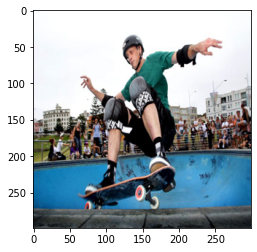

In [7]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Радует, что не встречаются #UNK токены), хотя скейтборд угадался только в одном варианте
# в бейсик ноутбуке скейт был предсказан во всех вариантах((((

--2020-06-26 17:26:36--  https://varlamov.me/2019/miting_27iulya/11.jpg
Resolving varlamov.me (varlamov.me)... 46.4.154.43
Connecting to varlamov.me (varlamov.me)|46.4.154.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263095 (257K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 256.93K  --.-KB/s    in 0.04s   

2020-06-26 17:26:36 (6.93 MB/s) - ‘data/img.jpg’ saved [263095/263095]



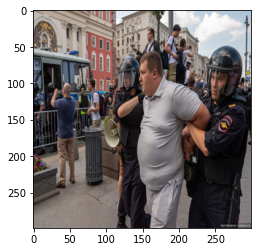

a man is sitting on a bench with a dog .
a man is holding a tennis racket on a court .
a man is holding a remote control in his hand .
a man in a black shirt is playing tennis
a man is sitting on a bench with a dog .
a man sitting on a bench with a dog .
a man is sitting on a bench with a dog .
a man is holding a tennis racket and a ball .
a man in a black jacket and a red jacket riding a motorcycle .
a man in a suit and tie with a mask on it


In [8]:
!wget https://varlamov.me/2019/miting_27iulya/11.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Бейсик ноутбук давал "a group of people standing..." для всех 10 вариантов,
# здесь же из пушки по воробьям. эх((((((((
# Наверно, модель отдает самые частотные варианты токенов

--2020-06-26 13:12:25--  https://avatars.mds.yandex.net/get-zen_doc/1550999/pub_5d47cb639c944600aede3203_5d494266ddfef600add60989/scale_1200
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.184, 87.250.247.182, 87.250.247.181, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100934 (99K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  98.57K   270KB/s    in 0.4s    

2020-06-26 13:12:26 (270 KB/s) - ‘data/img.jpg’ saved [100934/100934]



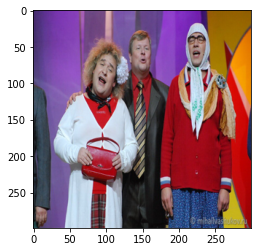

a man is sitting on a bench with a dog .
a man in a black suit and a black hat is walking down the street
a man in a black shirt is holding a plate of food .
a man in a suit stands next to a woman .
a man in a black shirt is playing a game of tennis .
a man riding a skateboard up the side of a ramp .
a man is standing in a bathroom with a sink
a man in a black suit and a black jacket talking on a cell phone
a man is holding a tennis racket and a ball .
a man is sitting on a bench with a dog .


In [19]:
!wget https://avatars.mds.yandex.net/get-zen_doc/1550999/pub_5d47cb639c944600aede3203_5d494266ddfef600add60989/scale_1200 -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Предсказания тоже далеки от картинки, хотя в бейсик варианте были:

# a group of people standing in a room with a dog .
# a group of people standing in a white dress holding a white umbrella .
# a woman in a dress shirt and a tie in a dress
# a group of people standing in a black and white dress
# a woman standing in a white dress holding a pink umbrella .
# a woman in a white shirt and a tie .
# a group of people standing in a small room with a dog .
# a woman standing in a white dress holding a red tie .
# a group of people standing in a room with a dog .
# a woman in a white dress holding a white umbrella .

--2020-06-26 13:12:54--  https://cdn.news-front.info/uploads/2017/01/tramp_putin_.jpeg
Resolving cdn.news-front.info (cdn.news-front.info)... 104.31.3.185, 104.31.2.185, 2606:4700:3038::681f:3b9, ...
Connecting to cdn.news-front.info (cdn.news-front.info)|104.31.3.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197260 (193K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 192.64K   398KB/s    in 0.5s    

2020-06-26 13:12:57 (398 KB/s) - ‘data/img.jpg’ saved [197260/197260]



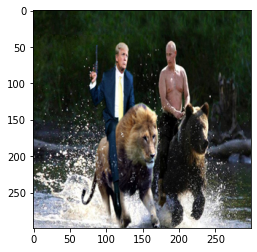

a man in a black shirt and a tie .
a man is holding a tennis racket on a court .
a man is sitting on a bench in the snow .
a man is holding a tennis racket in hand .
a man in a black suit and a black jacket talking on a cell phone
a man is sitting on a bench with a dog .
a man in a black shirt is playing a video game .
a man on a skateboard is performing tricks .
a man is standing on a tennis court holding a racquet .
a man is playing tennis on a tennis court .


In [20]:
!wget https://cdn.news-front.info/uploads/2017/01/tramp_putin_.jpeg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Снова размыто, и токены про собаку, костюм и сидение скорее случайны

# Бейсик ноутбуку тоже было тяжело, но варианты он дал получше:

# a man is standing in the grass with a dog .
# a large black and white photo of a woman in a black and white photo .
# a black and white photo of a woman in a black and white photo .
# a large black and white photo of a man in a field
# a group of people standing on top of a brown horse .
# a large brown and white dog standing in a field .
# a large black and white photo of a man in a field .
# a large black and white photo of a woman in a black and white photo .
# a group of people standing on top of a brown horse .
# a large black and white photo of a man in a field .

--2020-06-26 13:13:24--  https://img.kanzoboz.ru/data/images/454694_80505_th.jpg
Resolving img.kanzoboz.ru (img.kanzoboz.ru)... 144.76.174.120
Connecting to img.kanzoboz.ru (img.kanzoboz.ru)|144.76.174.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38650 (38K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  37.74K  --.-KB/s    in 0s      

2020-06-26 13:13:25 (155 MB/s) - ‘data/img.jpg’ saved [38650/38650]



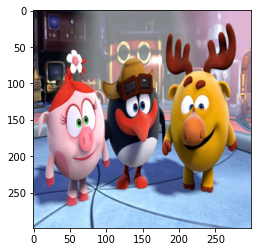

a man is sitting on a bench with a dog .
a man with a tennis racket runs with a racket .
a man is sitting on a bench with a dog .
a man is sitting on a bench with a backpack .
a man is sitting on a bench with a dog .
a man is standing on a tennis court holding a racquet .
a man in a suit jacket and tie .
a man wearing a black suit and a tie .
a man is holding a tennis racket and a ball .
a man is standing in a bathroom with a sink .


In [21]:
!wget https://img.kanzoboz.ru/data/images/454694_80505_th.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Картинка сложная, но бейсик хотя бы говорил о "a group of teddy bears..."

--2020-06-26 13:13:46--  https://static.rfstat.com/mockup-maker/mockups/429/944797608951ef6f34fdf23f2de99732.jpg
Resolving static.rfstat.com (static.rfstat.com)... 104.26.4.228, 104.26.5.228, 172.67.73.120, ...
Connecting to static.rfstat.com (static.rfstat.com)|104.26.4.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174638 (171K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 170.54K  --.-KB/s    in 0.03s   

2020-06-26 13:13:46 (4.87 MB/s) - ‘data/img.jpg’ saved [174638/174638]



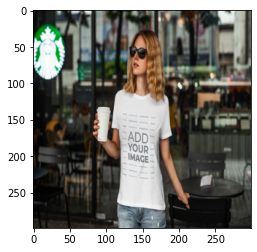

a man in a black shirt and a black hat
a man is holding a tennis racket on a court .
a man is on a surfboard in the ocean .
a man in a black shirt and black pants wiping out on the back of a motorcycle .
a man standing next to a woman with a tennis racket .
a man in a suit and tie with a mask on it
a man is riding a skateboard on a ramp .
a man riding a skateboard up the side of a ramp .
a man in a black shirt and a black hat is standing in the snow .
a man is sitting on a bench with a backpack .


In [22]:
!wget https://static.rfstat.com/mockup-maker/mockups/429/944797608951ef6f34fdf23f2de99732.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [10]:
# Провал, тут даже "woman" не предлагается. Феминистки не одобрят.
# На лекции по CV рассказывали о кейсе, когда сеть приравнивала лица людей
# азиатской внешности, так что неудачи бывают у всех)

--2020-06-26 13:14:32--  https://pbs.twimg.com/media/B-a9FDQIcAAadim.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.173.16, 2606:2800:220:13d:2176:94a:948:148e
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.173.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186980 (183K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 182.60K  --.-KB/s    in 0.02s   

2020-06-26 13:14:32 (7.65 MB/s) - ‘data/img.jpg’ saved [186980/186980]



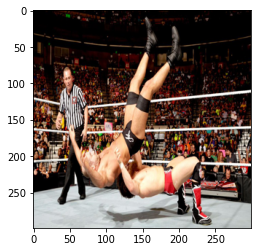

a man is sitting on a bench with a dog .
a man sitting on a bench with a dog .
a man in a black suit and a black jacket and a black mask
a man is holding a tennis racket on a court .
a man is standing on a tennis court holding a racquet .
a man in a black shirt and black pants wiping out on a skateboard .
a man in a black shirt and a black hat is holding a bat
a man is sitting on a bench with a dog .
a person riding a snowboard on a snow covered slope .
a man is holding a tennis racket on a court .


In [23]:
!wget https://pbs.twimg.com/media/B-a9FDQIcAAadim.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# На этой картинке бейсин ноутбук тоже не справился, но в одном из вариантов
# хотя бы дал слово бикини

--2020-06-26 13:14:53--  https://static6.depositphotos.com/1026266/626/i/950/depositphotos_6264533-stock-photo-happy-man-on-the-boat.jpg
Resolving static6.depositphotos.com (static6.depositphotos.com)... 104.81.183.242
Connecting to static6.depositphotos.com (static6.depositphotos.com)|104.81.183.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118784 (116K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 116.00K   770KB/s    in 0.2s    

2020-06-26 13:14:53 (770 KB/s) - ‘data/img.jpg’ saved [118784/118784]



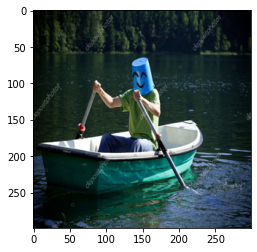

a man is riding a wave on a surfboard .
a man is holding a tennis racket on a court .
a man in a black shirt is eating a hot dog .
a man holding a cell phone in his hand .
a man in a black jacket and a black hat holding a white umbrella .
a man in a black shirt is eating a hot dog .
a man is holding a tennis racket and a ball .
a man on a skateboard is in the air
a man is sitting on a bench with a backpack .
a man in a black shirt is playing tennis


In [24]:
!wget https://static6.depositphotos.com/1026266/626/i/950/depositphotos_6264533-stock-photo-happy-man-on-the-boat.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [11]:
# Мне кажется, это первое попадание сети, ведь в первом варианте речь о прогулке по воде.
# Но бейсик сказал это для всех 10 вариантов

--2020-06-26 13:15:11--  http://kp-pravda.ru/wp-content/uploads/2019/06/%D0%B4%D0%B5%D1%82%D0%B8-%D1%84%D1%83%D1%82%D0%B1%D0%BE%D0%BB.jpg
Resolving kp-pravda.ru (kp-pravda.ru)... 80.93.177.84
Connecting to kp-pravda.ru (kp-pravda.ru)|80.93.177.84|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2179166 (2.1M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   2.08M  1.69MB/s    in 1.2s    

2020-06-26 13:15:13 (1.69 MB/s) - ‘data/img.jpg’ saved [2179166/2179166]



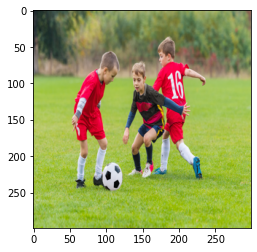

a man is holding a tennis racket in hand .
a man with a tennis racket runs in the air .
a man is on a surfboard in the ocean .
a man on a skateboard in the air .
a man in a black jacket and a black hat and a tie
a man standing on a tennis court holding a racquet .
a man in a suit and tie looking at the camera .
a man in a suit and tie with a mask on the back .
a man is sitting on a bench with a backpack .
a person is sitting on a bench overlooking a body of water .


In [25]:
!wget http://kp-pravda.ru/wp-content/uploads/2019/06/%D0%B4%D0%B5%D1%82%D0%B8-%D1%84%D1%83%D1%82%D0%B1%D0%BE%D0%BB.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Плохо

--2020-06-26 13:15:32--  https://avatars.mds.yandex.net/get-zen_doc/751940/pub_5db0aa01d4f07a00adee88bc_5db0aeb3e882c300b220954c/scale_1200
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.184, 87.250.247.182, 87.250.247.181, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273249 (267K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 266.84K   400KB/s    in 0.7s    

2020-06-26 13:15:34 (400 KB/s) - ‘data/img.jpg’ saved [273249/273249]



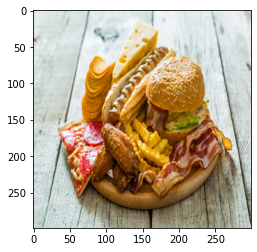

a man in a black suit rides a skateboard .
a man holding a tennis racquet on a tennis court .
a man is sitting on a bench with a dog .
a man is sitting on a bench in a park .
a man is sitting on a bench with a dog .
a man is holding a tennis racket on a court .
a man standing on a tennis court holding a racquet .
a man in a black shirt and a tie .
a man is sitting on a bench with a dog .
a man in a suit is standing next to a woman .


In [26]:
!wget https://avatars.mds.yandex.net/get-zen_doc/751940/pub_5db0aa01d4f07a00adee88bc_5db0aeb3e882c300b220954c/scale_1200 -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Ужасно(( Бейсик нормально распознал еду

--2020-06-26 13:15:51--  https://i.postimg.cc/MGjTTrNR/tas-tuglbeton-duvar-resimleri-brick-texture-Gozdeforum-Forumelel.jpg
Resolving i.postimg.cc (i.postimg.cc)... 104.238.220.13
Connecting to i.postimg.cc (i.postimg.cc)|104.238.220.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124978 (122K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 122.05K  --.-KB/s    in 0.1s    

2020-06-26 13:15:52 (1.00 MB/s) - ‘data/img.jpg’ saved [124978/124978]



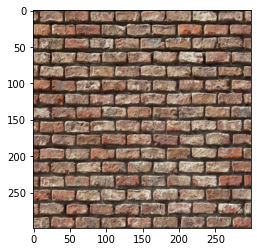

a man in a black suit and a black hat is standing on a skateboard .
a man is sitting on a bench with a skateboard .
a man in a black shirt and a tie .
a man in a black shirt and a black hat
a man in a suit and tie standing next to a woman .
a man is sitting on a bench with a dog .
a man is sitting on a bench with a dog .
a man in a suit and tie holding a glass of wine .
a man in a black shirt and a black hat holding a white umbrella
a man in a black shirt is eating a hot dog .


In [27]:
!wget https://i.postimg.cc/MGjTTrNR/tas-tuglbeton-duvar-resimleri-brick-texture-Gozdeforum-Forumelel.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Плохо, бейсик распознал тут улицу и дорожные знаки

--2020-06-26 18:07:44--  https://pm1.narvii.com/6764/363bdba07406091bddf4fa21a29089048fed480dv2_hq.jpg
Resolving pm1.narvii.com (pm1.narvii.com)... 54.192.87.81, 54.192.87.123, 54.192.87.104, ...
Connecting to pm1.narvii.com (pm1.narvii.com)|54.192.87.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62030 (61K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  60.58K  --.-KB/s    in 0.007s  

2020-06-26 18:07:44 (8.82 MB/s) - ‘data/img.jpg’ saved [62030/62030]



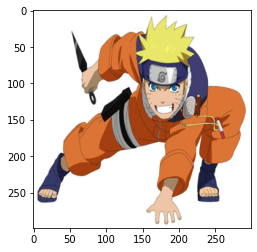

a man in a suit and tie looking at the camera .
a man in a black shirt rides a skateboard .
a man in a black suit and a black jacket and a black mask
a man in a suit and tie with a mask on .
a man is sitting on a bench with a backpack .
a man is on a skateboard in a skate park .
a man is on a skateboard in a skate park .
a man on a skateboard is performing tricks on a ramp .
a man in a black shirt and a tie
a man in a black shirt and a black hat


In [22]:
!wget https://pm1.narvii.com/6764/363bdba07406091bddf4fa21a29089048fed480dv2_hq.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
# Снова плохо. "sitting" встречается столько же раз, как и для картинки со стеной))

# Бейсик отвечал вменяемо:
# a man is holding a pair of skis on a snow covered slope .
# a young boy wearing a helmet and a helmet is holding a snowboard .
# a man is posing for a picture with a snowboard .
# a young child is holding a snowboard while standing on a snow covered slope .
# a young child is wearing a helmet and a backpack .
# a young child is wearing a red jacket and white pants .
# a person wearing a red jacket and a red jacket on a snowboard .
# a young boy wearing a helmet and a hat .
# a child in a red jacket skiing on a snow covered slope .
# a child wearing a helmet and a backpack is holding a snowboard .

In [21]:
# Ячейка для наглядности, мол модель действительно берет на вход 2048х8х8

with torch.no_grad():
  img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)

  vectors_8x8, vectors_neck, logits = inception(img[None])

  print(vectors_8x8.shape)
  
  caption_prefix = ['#START#']
  prefix_ix = as_matrix([caption_prefix])
  prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
  next_word_logits = network.forward(vectors_8x8.to(device), prefix_ix)[0, -1]
  
  print(next_word_logits.shape) # 9452 такая же длина у списка токенов

torch.Size([1, 2048, 8, 8])
torch.Size([9452])


## Вывод

Модель плохо обучилась, много данных != хорошие результаты.

Если бы еще было время на использование AWS, то уверен, можно было бы поработать с архитектурой модели, чтобы результаты улучшились.

### What else to try

If you're made it this far you're awesome and you should know it already. All the tasks below are completely optional and may take a lot of your time. Proceed at your own risk

#### Hard attention

* There are more ways to implement attention than simple softmax averaging. Here's [a lecture](https://www.youtube.com/watch?v=_XRBlhzb31U) on that. 
* We recommend you to start with [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) or [sparsemax](https://arxiv.org/abs/1602.02068) attention.

#### Reinforcement learning

* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week7](https://github.com/yandexdataschool/Practical_RL/tree/spring19/week7_seq2seq)
* Theory: https://arxiv.org/abs/1612.00563

#### Chilling out

This is the final and the most advanced task in the DL course. And if you're doing this with the on-campus YSDA students, it should be late spring by now. There's got to be a better way to spend a few days than coding another deep learning model. If you have no idea what to do, ask Yandex. Or your significant other.

![img](https://imgs.xkcd.com/comics/computers_vs_humans.png)